# VAE Implementation 

In [1]:
import node
import numpy as np

CPU Mode


In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
num_in_units = 28 * 28 # input size
num_h_units = 256
num_out_units = 2 # dim of hidden representation

In [3]:
class Encoder(node.Network):
    
    def __init__(self, 
                 num_in_units, 
                 num_h_units, 
                 num_out_units=2): 
        self.layers = [
            node.Linear(num_in_units, num_h_units),
            node.Linear(num_h_units, num_h_units),
            node.Linear(num_h_units, num_out_units), # Mean Vec
            node.Linear(num_h_units, num_out_units)  # Cov
        ]
        
    def __call__(self, input):
        hidden = input
        hidden = self.layers[0](hidden).relu()
        hidden = self.layers[1](hidden).relu()
        return self.layers[2](hidden), self.layers[3](hidden)

encoder = Encoder(num_in_units, num_h_units, num_out_units)

In [4]:
class Decoder(node.Network):
    
    def __init__(self, 
                 num_in_units,
                 num_h_units, 
                 num_out_units):
        self.layers = [
            node.Linear(num_in_units, num_h_units),
            node.Linear(num_h_units, num_h_units),
            node.Linear(num_h_units, num_out_units)
        ]
        
    def __call__(self, input):
        hidden = input
        hidden = self.layers[0](hidden).relu()
        hidden = self.layers[1](hidden).relu()
        hidden = self.layers[2](hidden).sigmoid()
        return hidden
    
decoder = Decoder(num_out_units, num_h_units, num_in_units)

In [5]:
optimizer = node.Adam(
    encoder.get_parameters() + decoder.get_parameters(), 
    eta   = 0.001,
    decay = 0.0005
)

In [6]:
from node.node import _two_oprand_op

class KLDivergence(node.Op):
    
    def __init__(self, mean, ln_var, *args):
        super(KLDivergence, self).__init__()
        self.register(mean, ln_var)
        self.output = self.forward()
    
    def forward(self):
        mean, ln_var = self.cache
        ln_var.value = np.clip(ln_var.value, -5, 5)
        var = np.exp(ln_var.value)
        return np.mean((mean.value**2 + var - ln_var.value - 1) * 0.5)
    
    def backward(self, error):
        mean, ln_var = self.cache
        shape = [1] * len(mean.value.shape)
        mean.accumulate(np.tile(1, shape) * mean.value)
        ln_var.accumulate(np.tile(1, shape) * (0.5 * np.exp(ln_var.value) - 1))

@_two_oprand_op
def kl_divergence(self, x):
    return KLDivergence(self, x)
    
setattr(node.Node, "kl_divergence", kl_divergence)

In [7]:
def reparameterize(mu, ln_var):
    return ln_var * np.random.normal(size=mu.value.shape) + mu

In [8]:
def train(input): 
    # Construct computation graph
    mu, ln_var = encoder(input)
    hidden = reparameterize(mu, ln_var)
    output = decoder(hidden)
    loss = output.binary_cross_entropy(input) \
                + mu.kl_divergence(ln_var)
    
    # Update parameters
    optimizer.clear()
    loss.backward()
    optimizer.update()
    
    return loss.numpy()

In [9]:
dataset = node.MNIST(train=False, flatten=True)
dataloader = node.DataLoader(dataset, 100)

In [10]:
epoch = 10

In [24]:
for i in range(epoch):    
    
    loss = 0
    for input, _ in dataloader:
        loss += train(input / 255)
        
    print("epoch {0:3}, loss {1:.2f}".format(i, loss / len(dataloader)))

epoch   0, loss 1940.07


KeyboardInterrupt: 

In [22]:
mu = node.Node(np.random.randn(1, num_out_units))
output = decoder(mu)

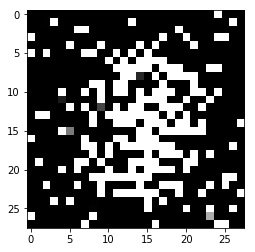

In [23]:
_, axis = plt.subplots(1)
axis.imshow(output.value[0].reshape(28, 28), cmap="gray")
plt.show()